In [3]:
#generate 100 minimal vc and pick the one with largest mass. Find sgw values afterward.

In [9]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import networkx as nx
import random


#####################

threshold = 1
gamma = 10
eps = 1e-2
eta = 1
verbose = False
nitermax = 20
#####################

random_state=1
np.random.seed(random_state)
#random.seed(random_state)

def generate_data(nsample, ratio):
    # Generate first ellipse
    s = np.random.uniform(size=(nsample, 3))
    x1 = np.zeros_like(s)
    x1[:, 0] = (
        np.sqrt(s[:, 0])
        * np.cos(2 * np.pi * s[:, 1])
        * np.cos(2 * np.pi * s[:, 2])
    )
    x1[:, 1] = 2 * np.sqrt(s[:, 0]) * np.sin(2 * np.pi * s[:, 1])
    x1[:, 2] = (
        np.sqrt(s[:, 0])
        * np.cos(2 * np.pi * s[:, 1])
        * np.sin(2 * np.pi * s[:, 2])
    )
    rot = 0.5 * np.sqrt(2) * np.array([[1, -1, 0], [1, 1, 0], [0, 0, 1]])
    x1 = x1.dot(rot)

    # Generate second circle
    s = np.random.uniform(size=(nsample, 3))
    x2 = np.zeros_like(s)
    x2[:, 0] = (
        np.sqrt(s[:, 0])
        * np.cos(2 * np.pi * s[:, 1])
        * np.cos(2 * np.pi * s[:, 2])
    )
    x2[:, 1] = np.sqrt(s[:, 0]) * np.sin(2 * np.pi * s[:, 1])
    x2[:, 2] = (
        np.sqrt(s[:, 0])
        * np.cos(2 * np.pi * s[:, 1])
        * np.sin(2 * np.pi * s[:, 2])
    )
    x2 = x2 + np.array([5.0, 0.0, 0.0])
    x = np.concatenate((x1, x2)) + np.array([0.0, 0.0, 8.0])

    # Generate second data drom translation
    y = np.concatenate((x1[:, :2], s[:, :2] + np.array([-4.0, 0.0])))
    angle = -np.pi / 4
    x[:nsample] = x[:nsample].dot(
        np.array(
            [
                [np.cos(angle), np.sin(angle), 0],
                [-np.sin(angle), np.cos(angle), 0],
                [0, 0, 1],
            ]
        )
    )
    y[nsample:] = (y[nsample:] - np.mean(y[nsample:], axis=0)).dot(
        np.array(
            [[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]
        )
    ) + np.mean(y[nsample:], axis=0)

    # Generate weights
    a, b = np.ones(x.shape[0]) / x.shape[0], np.ones(y.shape[0]) / y.shape[0]
    b[:n1], b[n1:] = (1 - ratio) * b[:n1], ratio * b[n1:]
    b = b / np.sum(b)
    return a, x, b, y

n1 = 20
ratio = 0.7
a, x, b, y = generate_data(n1, ratio)
x = np.array(x)
y = np.array(y)

C1 = sp.spatial.distance.cdist(x, x)
C2 = sp.spatial.distance.cdist(y, y)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(x[:, 0], x[:, 1], x[:, 2], color='red', label='mesh1')
# ax.scatter(y[:, 0], y[:, 1], color='blue', label='mesh2')

# ax.legend()
# plt.show()


n = C1.shape[0]
m = C2.shape[0]
  
# #build graph and find an approximation of min vertex covering
# G = nx.Graph()
# for i in range(n):
#     for j in range(m):
#         vertex = (i+1, j+1) 
#         G.add_node(vertex)

# tensor4 = np.zeros((n, m, n, m))

# C1_exp = C1[:, None, :, None]
# C2_exp = C2[None, :, None, :]
# tensor4 = (C1_exp - C2_exp)**2
    
# positions = np.where(tensor4 > threshold**2) 
# vertex_positions = positions[0] + 1, positions[1] + 1, positions[2] + 1,positions[3] + 1

# for i in range(len(positions[0])) :
#     first_elements = [arr[i-1] for arr in vertex_positions]
#     vertex1 = (first_elements[0],first_elements[1])
#     vertex2 = (first_elements[2],first_elements[3])
#     G.add_edge(vertex1, vertex2) 


In [11]:
# Function to find the vertex with most edges
def vertex_with_most_edges(graph):
    degrees = dict(graph.degree())     
    max_degree = max(degrees.values())
    max_degree_vertices = [vertex for vertex, degree in degrees.items() if degree == max_degree]

    return max_degree_vertices, max_degree

# Function to check if a set of vertices is a vertex cover
def is_vertex_cover(graph, vertices):
    covered_edges = set()
    for vertex in vertices:
        for neighbor in graph[vertex]:
            covered_edges.add(frozenset([vertex, neighbor]))
    return len(covered_edges) == graph.number_of_edges()

# Function to find the minimum vertex cover using brute-force
def minimum_vertex_cover(graph):
    vertices = list(graph.nodes)
    n = len(vertices)
    for r in range(1, n+1):
        for subset in itertools.combinations(vertices, r):
            if is_vertex_cover(graph, subset):
                return subset
    return None

# Function to check if a set is minimal
def is_minimal_vertex_cover(G, vertex_cover):
        # Check if the set covers all edges
        for u, v in G.edges():
            if u not in vertex_cover and v not in vertex_cover:
                return False  # The set does not cover all edges
        # Check for minimality
        for vertex in vertex_cover:
            # Try removing the vertex and see if it's still a vertex cover
            reduced_cover = vertex_cover - {vertex}
            if all(u in reduced_cover or v in reduced_cover for u, v in G.edges()):
                return False  # Found a smaller vertex cover
        return True  # The vertex cover is minimal

# Function to minimize vc to a minimal one
def minimize_vertex_cover(graph, initial_cover):
    """ Minimize the vertex cover """
    minimal_cover = initial_cover.copy()
    removed = True

    while removed:
        removed = False
        for vertex in list(minimal_cover):  # Create a list to avoid modifying the set during iteration
            minimal_cover.remove(vertex)
            if not is_vertex_cover(graph, minimal_cover):
                minimal_cover.add(vertex)
            else:
                removed = True  # A vertex was successfully removed

    return minimal_cover 

#Function of sOT
def perform_sOT_log(G, a, b, eps, options):

    niter = options['niter_sOT']
    # tol   = options['tol_sOT']
    f     = options['f_init']
    g     = options['g_init']
    M     = options['penalty']

    # Err = np.array([[1, 1]])

    for q in range(niter):   
        f = np.minimum(eps * np.log(a) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=1)+ 10**-20) + f, M)
        g = np.minimum(eps * np.log(b) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=0)+ 10**-20) + g, M)

    P = np.exp((f[:, None] + g[None, :] - G) / eps)
    
    return P, f, g

In [6]:
# get a list of minimal vc (not a efficient one)
def get_cover(
    D1: np.ndarray, 
    D2: np.ndarray,
    ratio: float = 0.0001,
    threshold: float = 0.02,
    random_state: int = 1,
    verbose: bool=False
):    

    np.random.seed(random_state)
    random.seed(random_state)

    n = D1.shape[0]
    m = D2.shape[0]
    C1 = D1.copy()
    C2 = D2.copy()
  
    #build graph and find an approximation of min vertex covering
    G = nx.Graph()


    tensor4 = np.zeros((n, m, n, m))

    C1_exp = C1[:, None, :, None]
    C2_exp = C2[None, :, None, :]
    tensor4 = (C1_exp - C2_exp)**2
    positions = np.where(tensor4 > threshold**2) 
    G = nx.Graph()
    G.add_edges_from(((p[0]+1, p[1]+1), (p[2]+1, p[3]+1)) for p in zip(*positions))  
    #print(f"Number of vertex: {G.number_of_nodes()}")
    
    tuples_set = set()
    B = G.copy()
    initial_random_add = int(G.number_of_nodes() * ratio)
    
    for i in range(initial_random_add):
        vertex = random.choice(list(B.nodes))
        B.remove_node(vertex)
        tuples_set.add(vertex)

    while B.edges:
        vertices, degree = vertex_with_most_edges(B)
        vertex = random.choice(vertices)
        B.remove_node(vertex)
        tuples_set.add(vertex)

        
    inf_mask = np.zeros([n, m])
    test = 0

    if is_minimal_vertex_cover(G, tuples_set):
        test = 1
        for (i, j) in tuples_set:
            inf_mask[i-1, j-1] = 1
    else:
        minimal_cover = tuples_set.copy()
        for vertex in tuples_set:
            # Remove the vertex and check if it's still a vertex cover
            minimal_cover.remove(vertex)
            if not is_vertex_cover(G, minimal_cover):
                # If not a vertex cover, add the vertex back
                minimal_cover.add(vertex)
        if is_minimal_vertex_cover(G, minimal_cover):
            test = 1
            for (i, j) in minimal_cover:
                inf_mask[i-1, j-1] = 1
        

    return inf_mask, test

In [7]:
import numpy as np
import networkx as nx
import random

def vertex_with_most_edges(B):
    max_degree = max(dict(B.degree()).values())
    vertices = [v for v, d in B.degree() if d == max_degree]
    return vertices, max_degree

def is_vertex_cover(G, cover):
    for u, v in G.edges():
        if u not in cover and v not in cover:
            return False
    return True

def is_minimal_vertex_cover(G, cover):
    if not is_vertex_cover(G, cover):
        return False
    for vertex in list(cover):
        cover.remove(vertex)
        if is_vertex_cover(G, cover):
            return False
        cover.add(vertex)
    return True

def get_cover_4o(
    D1: np.ndarray, 
    D2: np.ndarray,
    ratio: float = 0.0001,
    threshold: float = 0.02,
    random_state: int = 1,
    verbose: bool=False
):    
    np.random.seed(random_state)
    random.seed(random_state)

    n = D1.shape[0]
    m = D2.shape[0]
  
    # Build graph
    G = nx.Graph()

    # Efficient tensor4 calculation
    C1_exp = D1[:, None, :, None]
    C2_exp = D2[None, :, None, :]
    tensor4 = (C1_exp - C2_exp) ** 2
    positions = np.where(tensor4 > threshold ** 2)
    
    G.add_edges_from(((p[0] + 1, p[1] + 1), (p[2] + 1, p[3] + 1)) for p in zip(*positions))
    
    tuples_set = set()
    B = G.copy()
    initial_random_add = int(G.number_of_nodes() * ratio)
    
    for i in range(initial_random_add):
        vertex = random.choice(list(B.nodes))
        B.remove_node(vertex)
        tuples_set.add(vertex)

    while B.edges:
        vertices, degree = vertex_with_most_edges(B)
        vertex = random.choice(vertices)
        B.remove_node(vertex)
        tuples_set.add(vertex)

    inf_mask = np.zeros([n, m])
    test = 0

    if is_minimal_vertex_cover(G, tuples_set):
        test = 1
        for (i, j) in tuples_set:
            inf_mask[i-1, j-1] = 1
    else:
        minimal_cover = tuples_set.copy()
        for vertex in tuples_set:
            minimal_cover.remove(vertex)
            if not is_vertex_cover(G, minimal_cover):
                minimal_cover.add(vertex)
        if is_minimal_vertex_cover(G, minimal_cover):
            test = 1
            for (i, j) in minimal_cover:
                inf_mask[i-1, j-1] = 1

    return inf_mask, test


In [8]:
n_exp = 100
value = 1
rhos = np.full(n_exp, value)
ratios = np.random.uniform(0.0001, 0.8000, n_exp)
a = np.ones([C1.shape[0]])/C1.shape[0]
b = np.ones([C2.shape[0]])/C2.shape[0]
sot_options = {'penalty': 10, 'niter_sOT': 10000, 'f_init': np.zeros_like(a), 'g_init': np.zeros_like(b)}
A_sum_list = []
P_sum_list = []
Ratio_list = []
A_matrices_list = []

for i in range(n_exp):
    A, test = get_cover_4o(C1, C2, threshold=rhos[i], ratio=ratios[i])
    if test == 0:
        print("error")
        break
        
    if test == 1:
        C = np.ones_like(A)
        C[np.where(A>0)] = np.inf
        P,_,_ = perform_sOT_log(C, a, b, 0.01, sot_options)
        print(i, int(A.sum()), P.sum(), ratios[i])
        A_sum_list.append(int(A.sum()))
        P_sum_list.append(P.sum())
        Ratio_list.append(ratios[i])
        A_matrices_list.append(A)
        

A_matrices_tensor = np.array(A_matrices_list)
np.save('synthetic_matrices_rho_1_true.npy', A_matrices_tensor)

np.save('synthetic_A_sum_rho_1_true.npy', A_sum_list)
np.save('synthetic_P_sum_rho_1_true.npy', P_sum_list)
np.save('synthetic_Ratio_rho_1_true.npy', Ratio_list)

##############################################
# A_matrices_tensor = np.load('synthetic_A_matrices_rho_1_true.npy')
# A_sum_list = np.load('synthetic_A_sum_rho_1_true.npy')
# P_sum_list = np.load('synthetic_P_sum_rho_1_true.npy')
# Ratio_list = np.load('synthetic_Ratio_rho_1_true.npy')




0 1365 0.6250000000000038 0.01600211905845249
1 1365 0.6250000000000016 0.021066168403487653
2 1362 0.6000000000000094 0.022742359767833606
3 1366 0.6249999999999907 0.19704423297567641
4 1393 0.6250000000000067 0.6880363561514422
5 1378 0.6500000000000239 0.4311109683668881
6 1381 0.6750000000000193 0.44230230075074417
7 1388 0.6000000000000162 0.6736405107984487
8 1365 0.6249999999999951 0.09942623476441693
9 1365 0.600000000000013 0.22341902484101048
10 1386 0.7000000000000057 0.46864884123948447
11 1394 0.6750000000000035 0.7756796390809078
12 1383 0.6500000000000106 0.4488680723826424
13 1363 0.5750000000000073 0.015015966769417122
14 1385 0.6250000000000047 0.640526074877225
15 1365 0.6000000000000023 0.18645612164543224
16 1393 0.6250000000000167 0.6457034459754615
17 1374 0.6750000000000098 0.310349729186931
18 1393 0.6750000000000151 0.690847129462087
19 1391 0.7250000000000136 0.597722602025474
20 1387 0.700000000000018 0.4450365631689361
21 1363 0.6000000000000136 0.10925053

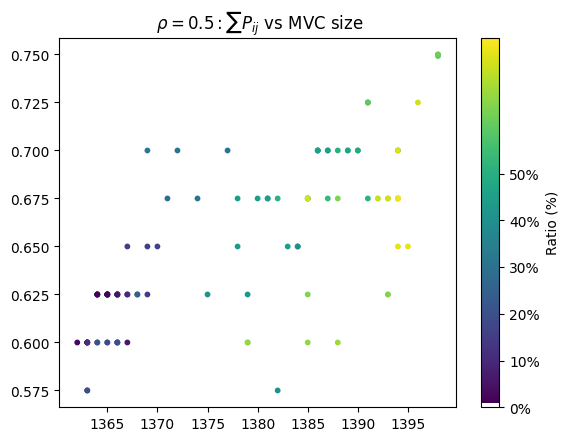

In [6]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import networkx as nx
import random

A_matrices_tensor = np.load('synthetic_matrices_rho_1_true.npy')
A_sum_list = np.load('synthetic_A_sum_rho_1_true.npy')
P_sum_list = np.load('synthetic_P_sum_rho_1_true.npy')
Ratio_list = np.load('synthetic_Ratio_rho_1_true.npy')
scatter = plt.scatter(A_sum_list, P_sum_list, s=10, c=Ratio_list)
cbar = plt.colorbar(scatter)
cbar.set_label('Ratio (%)')
cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
cbar.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
plt.title(r' $\rho=0.5 : \sum P_{ij}$ vs MVC size')
plt.savefig('synthetic_true_0521.png')
# plt.figure(figsize=(6.4, 6.4))
# scatter = plt.scatter(A_sum_list, P_sum_list, s=10, c=Ratio_list)
# cbar = plt.colorbar(scatter)
# cbar.set_label('Ratio (%)', fontsize=20)
# cbar.set_ticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
# cbar.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
# cbar.ax.tick_params(labelsize=20)

# plt.xlabel('Size of MVC', fontsize=20)  
# plt.ylabel('Transported Mass', fontsize=20) 
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5)) 
# plt.title(r' $\rho=1$', fontsize=20)
# plt.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig('sythetic_true.png')
# plt.show

In [7]:
# Find the indices of the maximum value in P_sum_list
max_P_sum_value = np.max(P_sum_list)
max_indices = np.where(P_sum_list == max_P_sum_value)[0]

# Among these indices, find the one with the smallest ratio in Ratio_list
#min_ratio_index = max_indices[np.argmin(Ratio_list[max_indices])]
min_ratio_index = random.choice(max_indices)

# Get the corresponding matrix A
corresponding_A_matrix = A_matrices_tensor[min_ratio_index]

# Find the nonzero locations of the matrix A
nonzero_indices = np.argwhere(corresponding_A_matrix > 0)

# Convert the nonzero indices to a set of tuples representing the vertex cover
tuples_set = set(tuple(idx+1) for idx in nonzero_indices)

# Print the minimum vertex cover set
print(f"The index of the largest P_sum_list value is: {min_ratio_index}")
print(f"The largest P_sum_list value is: {P_sum_list[min_ratio_index]}")
print("The corresponding matrix A is:")
print(corresponding_A_matrix)
print("The minimum vertex cover set (mvc) is:")
print(tuples_set)

The index of the largest P_sum_list value is: 73
The largest P_sum_list value is: 0.7499999999999987
The corresponding matrix A is:
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 1. 0. 1.]]
The minimum vertex cover set (mvc) is:
{(18, 17), (8, 9), (19, 18), (11, 14), (34, 3), (37, 8), (3, 15), (22, 28), (14, 24), (38, 9), (15, 25), (7, 21), (18, 30), (30, 4), (33, 15), (25, 11), (10, 31), (2, 27), (22, 5), (14, 1), (34, 16), (37, 21), (3, 28), (14, 37), (15, 2), (26, 11), (18, 7), (21, 18), (40, 31), (6, 38), (10, 8), (2, 40), (3, 5), (22, 18), (14, 14), (17, 25), (36, 38), (40, 8), (6, 15), (21, 31), (33, 5), (25, 1), (10, 21), (2, 17), (34, 6), (13, 32), (37, 11), (3, 18), (16, 37), (36, 15), (26, 1), (5, 27), (17, 38), (9, 34), (29, 12), (21, 8), (6, 28), (33, 18), (25, 14), (32, 22), (2, 30), (22, 8), (35, 27), (14, 4), (1, 34), (17, 15), (36, 28), (9, 11), (28, 24), (5, 40), (6, 5), (

51.3343948006165


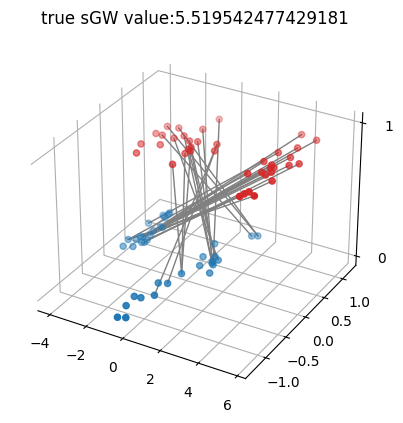

5.519542477429181


In [12]:
#####################

threshold = 1
gamma = 10
eps = 1e-2
eta = 1
verbose = False
nitermax = 20
#####################
a = np.array([1 / n] * n, dtype=float)
aa = a + 1e-1 * np.random.rand(n)
b = np.array([1 / m] * m, dtype=float)
bb = b + 1e-1 * np.random.rand(m)

aa = aa / np.linalg.norm((aa), ord=1)
bb = bb / np.linalg.norm((bb), ord=1)
tensor4 = (C1 - C2)**2    
#real convergence value
#eta = eps/(np.sqrt(2)* n * m * min(np.max(a), np.max(b)) * max(np.max(C1)**2,np.max(C2)**2) + eps)
    
    
P = np.outer(aa, bb) 
f = np.zeros(n)
g = np.zeros(m)
p_values = range(nitermax)
sgw_values = []

print(max(np.max(C1)**2,np.max(C2)**2))

for p in p_values:
        
    D = np.zeros((n, m)) 
    P_reshaped = P.reshape(1, 1, n, m) 
    D = np.sum(tensor4 * P_reshaped, axis=(-2, -1))
    sgw = np.sum(D * P)+gamma*(np.sum(a)+np.sum(b)-2*np.sum(P))+eps*np.sum(P * (np.log(P+10**(-20)*np.ones((n,m)))-np.ones((n,m))))
    sgw_values.append(sgw)
    
    D = 2*eta*D+eps*(eta-1)*np.log(P+10**(-20)*np.ones((n,m)))
                    
    for s, t in tuples_set:
        D[s-1, t-1] = np.inf
        
    options = {
    'niter_sOT': 10**5,
    'f_init': np.zeros(n),
    'g_init': np.zeros(m),
    'penalty': eta*gamma
    }
        
    P,f,g = perform_sOT_log(D, a, b, eps, options)

######################################################################################
#######################################################################################

def plot_mapping(P,X_1,X_2, thresh=None, linewidth=1, save_path=None):

    fig = plt.figure()
    
    ax = plt.axes(projection='3d') 
    ax.scatter3D(X_1[:,0], X_1[:,1], 0, c='tab:blue')
    ax.scatter3D(X_2[:,0], X_2[:,1], 1, c='tab:red')
    ax.set_title('true sGW value:' + str(sgw_values[19]))
    
    for i in range(P.shape[1]):
        if P[:,i].sum() < thresh: continue
        j = np.argmax(P[:,i])
        ax.plot3D([X_1[j,0], X_2[i,0]],[X_1[j,1], X_2[i,1]],[0,1],c='gray', linewidth=linewidth)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_zticks([0, 1])
    
        
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
plot_mapping(P, y, x, thresh=0.00000001, save_path='synthetic_true.png')
np.savetxt('synthetic_true.csv', P, delimiter=',', fmt='%.10f')
print(sgw_values[19])

In [13]:
P_sum_list

array([0.625     , 0.625     , 0.6       , 0.625     , 0.625     ,
       0.65      , 0.675     , 0.6       , 0.625     , 0.6       ,
       0.7       , 0.675     , 0.65      , 0.575     , 0.625     ,
       0.6       , 0.625     , 0.675     , 0.675     , 0.725     ,
       0.7       , 0.6       , 0.625     , 0.625     , 0.625     ,
       0.625     , 0.6       , 0.7       , 0.675     , 0.6       ,
       0.625     , 0.675     , 0.7       , 0.65      , 0.575     ,
       0.725     , 0.65      , 0.7       , 0.675     , 0.6       ,
       0.6       , 0.575     , 0.675     , 0.6       , 0.6       ,
       0.625     , 0.625     , 0.65      , 0.7       , 0.7       ,
       0.625     , 0.675     , 0.7       , 0.7       , 0.675     ,
       0.725     , 0.675     , 0.625     , 0.625     , 0.675     ,
       0.7       , 0.625     , 0.75      , 0.625     , 0.625     ,
       0.675     , 0.65      , 0.675     , 0.625     , 0.675     ,
       0.6       , 0.6       , 0.74921645, 0.75      , 0.675  

In [14]:
#plot 232

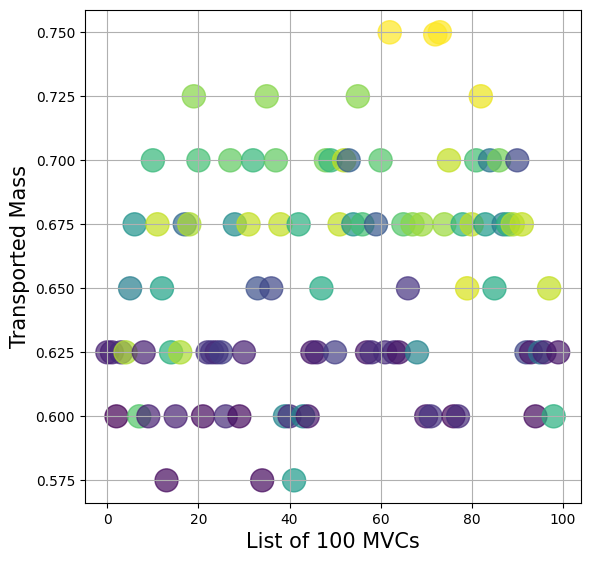

In [25]:
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.colors as mcolors
# import matplotlib.cm as cm

# # Data
# A_sum_list = np.load('synthetic_A_sum_rho_1_true.npy')
# P_sum_list = np.load('synthetic_P_sum_rho_1_true.npy')

# # Normalizing the size for better visualization
# sizes = np.array(A_sum_list) * 0.2  # Scale factor for visibility, adjust as needed

# # Create a color map based on MVC sizes
# unique_sizes = np.unique(A_sum_list)
# colors = cm.viridis(np.linspace(0, 1, len(unique_sizes)))
# color_map = {size: color for size, color in zip(unique_sizes, colors)}

# # Map MVC sizes to colors
# point_colors = [color_map[size] for size in A_sum_list]

# plt.figure(figsize=(6.4, 6.4))
# scatter = plt.scatter(range(len(P_sum_list)), P_sum_list, s=sizes, c=point_colors, alpha=0.7)
# #plt.title('SGW Values by MVC Size')
# plt.xlabel('List of 100 MVCs',fontsize=15)
# plt.ylabel('Transported Mass',fontsize=15)

# # Create a custom legend
# handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'MVC Size {size}', 
#                       markerfacecolor=color, markersize=1) for size, color in color_map.items()]
# plt.legend(handles=handles)

# plt.grid(True)
# plt.savefig('synthetic_P_sum_all_color.png', dpi=300, bbox_inches='tight')
# plt.show()

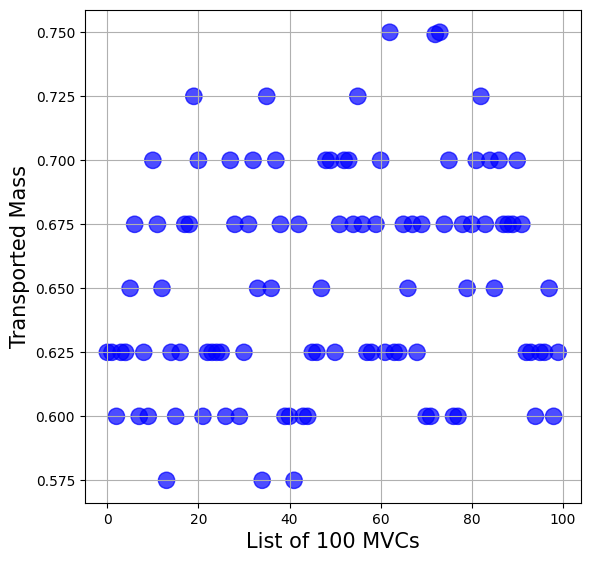

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Data
A_sum_list = np.load('synthetic_A_sum_rho_1_true.npy')
P_sum_list = np.load('synthetic_P_sum_rho_1_true.npy')

# Normalizing the size for better visualization
sizes = np.array(A_sum_list) * 0.1  # Scale factor for visibility, adjust as needed

# Set a single color for all points
single_color = 'blue'  # You can change this to any color you prefer

plt.figure(figsize=(6.4, 6.4))
plt.scatter(range(len(P_sum_list)), P_sum_list, s=sizes, c=single_color, alpha=0.7)
plt.xlabel('List of 100 MVCs', fontsize=15)
plt.ylabel('Transported Mass', fontsize=15)
plt.grid(True)
plt.savefig('synthetic_P_sum_all.png', dpi=300, bbox_inches='tight')
plt.show()


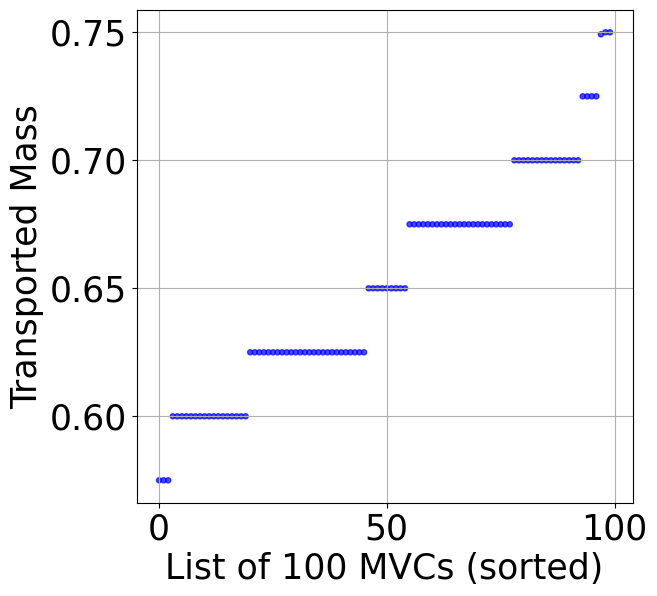

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Data
A_sum_list = np.load('synthetic_A_sum_rho_1_true.npy')
P_sum_list = np.load('synthetic_P_sum_rho_1_true.npy')

# Normalizing the size for better visualization
sizes = np.array(A_sum_list) * 0.01  # Scale factor for visibility, adjust as needed

# Sort P_sum_list and get sorted indices
sorted_indices = np.argsort(P_sum_list)
sorted_P_sum_list = P_sum_list[sorted_indices]
sorted_sizes = sizes[sorted_indices]

# Set a single color for all points
single_color = 'blue'  # You can change this to any color you prefer

plt.figure(figsize=(6.4, 6.4))
plt.scatter(range(len(sorted_P_sum_list)), sorted_P_sum_list, s=sorted_sizes, c=single_color, alpha=0.7)
plt.xlabel('List of 100 MVCs (sorted)', fontsize=25)
plt.ylabel('Transported Mass', fontsize=25)
plt.tick_params(axis='x', labelsize=25)  # Adjust the font size as needed
plt.tick_params(axis='y', labelsize=25) 


plt.grid(True)
plt.savefig('synthetic_P_sum_all_sorted.png', dpi=300, bbox_inches='tight')
plt.show()
